In [1]:
import camb
import healpy as hp
import pysm3
import pysm3.units as u
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import pickle as pl
import time

In [2]:
nside = 1024

In [3]:
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,  As=2e-9, ns=0.965, halofit_version='mead', lmax=4000)
results = camb.get_results(pars)
lensed_cl = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['lensed_scalar']
cmb_map = hp.synfast(lensed_cl.T, nside=nside, new=True)

In [4]:
freqs = np.array(["27", "39", "93", "145", "225", "280"])
fwhm = np.array([7.4, 5.1, 2.2, 1.4, 1.0, 0.9])
nlev_p = np.array([23.6, 13.1, 2.3, 2.2, 4.8, 2.2])

In [5]:
sky = pysm3.Sky(nside=nside, preset_strings=["d0", "s0"])

In [6]:
def noise_map(nside,nlev_p):
    nl_p = np.ones(3*nside) * np.radians(nlev_p / 60.)**2
    nlev_t = nlev_p / np.sqrt(2)
    nl_t = np.ones(3*nside) * np.radians(nlev_t / 60.)**2
    cl_s = [nl_t, nl_p, nl_p, nl_p*0]
    return hp.synfast(cl_s, nside=nside, new=True)

def sky_map(freqs, fwhm, nlev_p, nside):
    maps = []
    for i in tqdm(range(len(freqs))):
        fg = sky.get_emission(int(freqs[i])*u.GHz)
        fg = fg.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(int(freqs[i])*u.GHz))
        signal = cmb_map + fg.value
        signal = hp.smoothing(signal, fwhm=np.radians(fwhm[i]/60.))
        noise = noise_map(nside, nlev_p[i])
        maps.append(signal + noise)
    return maps

In [7]:
sky_maps = sky_map(freqs, fwhm, nlev_p, nside)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [05:18<00:00, 53.02s/it]


In [8]:
sys.path.append('../')

In [9]:
%load_ext autoreload
%autoreload 2
from pynilc.nilc import NILC
from pynilc.needlets import NeedletTransform
from pynilc.sht import HealpixDUCC

In [10]:
bandcenters = np.array([0, 50, 100, 200, 300, 500, 700, 1000, 1350, 1700, 2000])
nfilters = NeedletTransform.CosineNeedlet(bandcenters)[:-1]

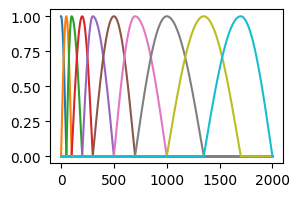

In [11]:
plt.figure(figsize=(3,2))
for i in range(len(nfilters)):
    plt.plot(nfilters[i])

In [12]:
nilc_hp = NILC(freqs, fwhm, nfilters, backend='healpy')
nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside)

In [13]:
st = time.time()
ilc_map_dc, ilc_weights_dc = nilc_dc.component_separation(sky_maps,field=1)
print(f"Time elapsed with ducc: {time.time()-st:.2f} s")

Computing E-mode alms


Computing alms:   0%|          | 0/6 [00:00<?, ?it/s]

Processing Needlet Scales: 100%|██████████| 10/10 [07:21<00:00, 44.15s/it]


Time elapsed with ducc: 452.83 s


In [14]:
st = time.time()
ilc_map_hp, ilc_weights_hp = nilc_hp.component_separation(sky_maps,field=1)
print(f"Time elapsed with healpy: {time.time()-st:.2f} s")

Computing E-mode alms


Processing Needlet Scales: 100%|██████████| 10/10 [08:53<00:00, 53.39s/it]


Time elapsed with healpy: 548.64 s


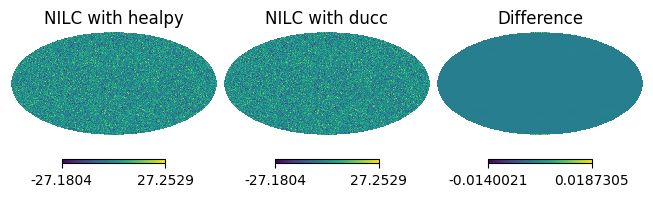

In [15]:
hp.mollview(ilc_map_hp, title='NILC with healpy', sub=(1,3,1))
hp.mollview(ilc_map_dc, title='NILC with ducc', sub=(1,3,2))
hp.mollview(ilc_map_hp-ilc_map_dc, title='Difference', sub=(1,3,3))

(2, 3000)

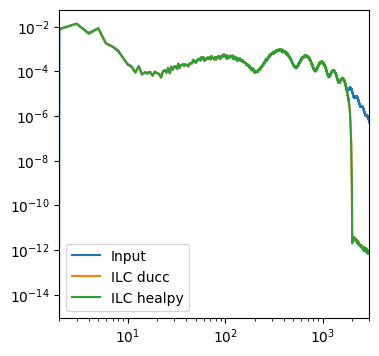

In [17]:
plt.figure(figsize=(4,4))
plt.loglog(hp.anafast(cmb_map)[1], label='Input')
plt.loglog(hp.anafast(ilc_map_dc), label='ILC ducc')
plt.loglog(hp.anafast(ilc_map_hp), label='ILC healpy')
plt.legend()
plt.xlim(2, 3000)